## Isolation Forest  defense mechanism

Labels and image shapes are valid.
Epoch 1, Loss: 0.1729, Accuracy: 98.20%, Precision: 0.98, F1-Score: 0.98
Epoch 2, Loss: 0.0484, Accuracy: 98.27%, Precision: 0.98, F1-Score: 0.98
Epoch 3, Loss: 0.0326, Accuracy: 98.87%, Precision: 0.99, F1-Score: 0.99
Epoch 4, Loss: 0.0240, Accuracy: 98.70%, Precision: 0.99, F1-Score: 0.99
Epoch 5, Loss: 0.0183, Accuracy: 99.16%, Precision: 0.99, F1-Score: 0.99


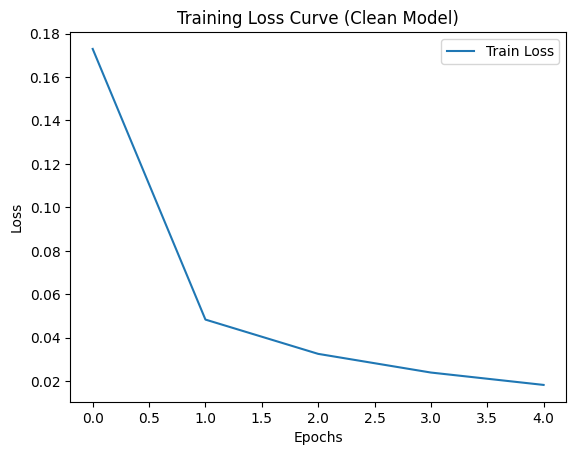

Clean model training and evaluation completed successfully!
Final Precision: 0.99, Final F1-Score: 0.99


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, f1_score
import matplotlib.pyplot as plt
import os

# Enable synchronous CUDA debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Define the CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load MNIST Dataset
def get_clean_data_loader():
    transform = transforms.Compose([transforms.ToTensor()])
    train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    return train_loader, test_loader

# Validate Dataset
def validate_dataset(data_loader):
    for images, labels in data_loader:
        # Check label range
        if labels.min() < 0 or labels.max() > 9:
            raise ValueError(f"Invalid labels found: {labels}")
        # Check image shape
        assert images.shape[1:] == (1, 28, 28), f"Unexpected image shape: {images.shape}"
        print("Labels and image shapes are valid.")
        break

# Train the Model
def train_model(model, train_loader, test_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, test_accuracies = [], []
    all_preds, all_labels = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluate the model
        model.eval()
        correct, total = 0, 0
        all_preds.clear()
        all_labels.clear()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        # Calculate Precision and F1-Score
        precision = precision_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}, F1-Score: {f1:.2f}")

    # Final metrics
    final_precision = precision_score(all_labels, all_preds, average='macro')
    final_f1 = f1_score(all_labels, all_preds, average='macro')

    return train_losses, test_accuracies, final_precision, final_f1

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Data
clean_train_loader, test_loader = get_clean_data_loader()

# Validate Data
validate_dataset(clean_train_loader)

# Train Clean Model
clean_model = SimpleCNN().to(device)
clean_losses, clean_accuracies, clean_precision, clean_f1 = train_model(clean_model, clean_train_loader, test_loader)

# Plot Training Curve
plt.plot(clean_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve (Clean Model)")
plt.legend()
plt.show()

print("Clean model training and evaluation completed successfully!")
print(f"Final Precision: {clean_precision:.2f}, Final F1-Score: {clean_f1:.2f}")


In [9]:
import numpy as np
from sklearn.metrics import precision_score, f1_score

# Load MNIST Dataset with Poisoning
def get_poisoned_data_loader():
    transform = transforms.Compose([transforms.ToTensor()])
    train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    # Apply a label-flipping attack (50% of training data)
    indices = np.random.choice(len(train_data), size=int(0.4 * len(train_data)), replace=False)
    for i in indices:
        train_data.targets[i] = (train_data.targets[i] + 1) % 10  # Flip label to next class

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

    return train_loader, test_loader

# Train the Model with Additional Metrics
def train_model_with_metrics(model, train_loader, test_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, test_accuracies = [], []
    all_preds, all_labels = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluate the model
        model.eval()
        correct, total = 0, 0
        all_preds.clear()
        all_labels.clear()
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        # Calculate Precision and F1-Score
        precision = precision_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}, F1-Score: {f1:.2f}")

    # Final metrics
    final_precision = precision_score(all_labels, all_preds, average='macro')
    final_f1 = f1_score(all_labels, all_preds, average='macro')

    return train_losses, test_accuracies, final_precision, final_f1

# Load Poisoned Data
poisoned_train_loader, _ = get_poisoned_data_loader()

# Train a CNN Model on Poisoned Data
poisoned_model = SimpleCNN().to(device)
poisoned_losses, poisoned_accs, poisoned_precision, poisoned_f1 = train_model_with_metrics(poisoned_model, poisoned_train_loader, test_loader)

# Print Final Metrics
print(f"Final Precision (Poisoned Model): {poisoned_precision:.2f}")
print(f"Final F1-Score (Poisoned Model): {poisoned_f1:.2f}")


Epoch 1, Loss: 0.9159, Accuracy: 78.95%, Precision: 0.84, F1-Score: 0.76
Epoch 2, Loss: 0.7443, Accuracy: 87.37%, Precision: 0.88, F1-Score: 0.87
Epoch 3, Loss: 0.7211, Accuracy: 92.61%, Precision: 0.93, F1-Score: 0.93
Epoch 4, Loss: 0.7078, Accuracy: 90.97%, Precision: 0.92, F1-Score: 0.91
Epoch 5, Loss: 0.6971, Accuracy: 86.23%, Precision: 0.89, F1-Score: 0.85
Final Precision (Poisoned Model): 0.89
Final F1-Score (Poisoned Model): 0.85


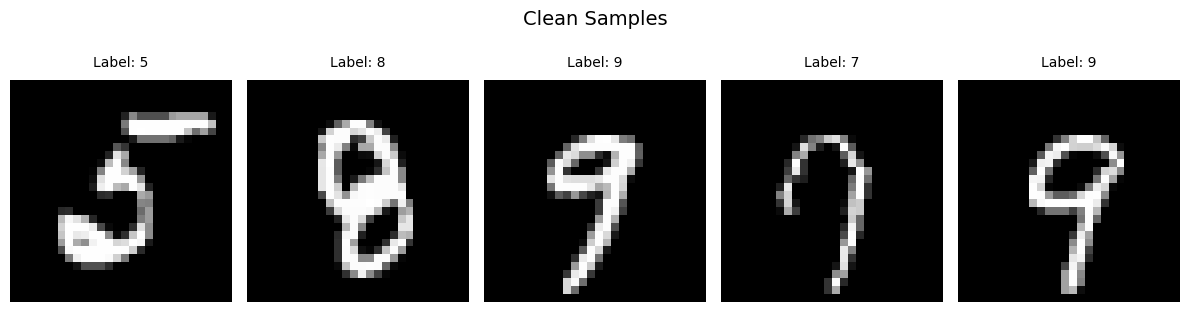

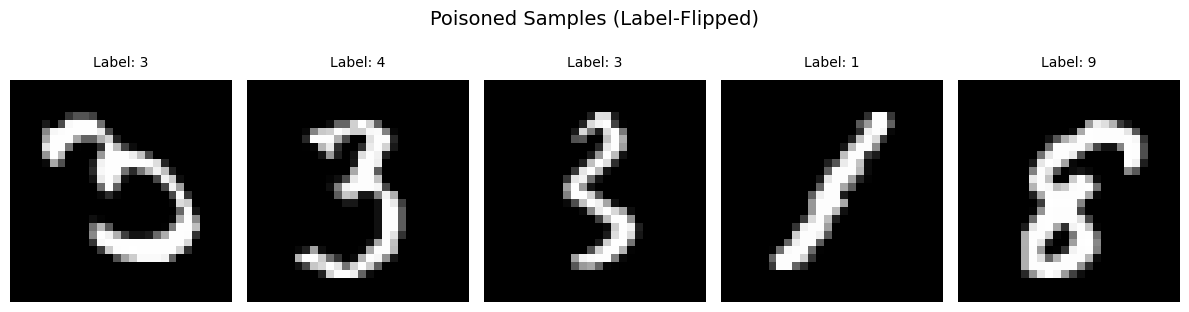

In [10]:
import matplotlib.pyplot as plt

# Function to visualize a batch of images with improved spacing
def visualize_samples(data_loader, title, num_samples=5):
    images, labels = next(iter(data_loader))  # Get a batch of images
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))  # Adjust figure size for better layout

    for i in range(num_samples):
        axes[i].imshow(images[i].squeeze(), cmap="gray")
        axes[i].set_title(f"Label: {labels[i].item()}", fontsize=10, pad=10)  # Add padding to the title
        axes[i].axis("off")

    plt.suptitle(title, fontsize=14, y=1.05)  # Adjust title position and size
    plt.tight_layout()  # Automatically adjust spacing
    plt.show()

# Visualize Clean Samples
visualize_samples(clean_train_loader, "Clean Samples")

# Visualize Poisoned Samples
visualize_samples(poisoned_train_loader, "Poisoned Samples (Label-Flipped)")


Defended dataset size: 54000 samples remaining after filtering.
Epoch 1, Loss: 0.9344, Accuracy: 82.04%, Precision: 0.83, F1-Score: 0.82
Epoch 2, Loss: 0.7475, Accuracy: 91.20%, Precision: 0.92, F1-Score: 0.91
Epoch 3, Loss: 0.7237, Accuracy: 85.50%, Precision: 0.89, F1-Score: 0.84
Epoch 4, Loss: 0.7083, Accuracy: 92.90%, Precision: 0.93, F1-Score: 0.93
Epoch 5, Loss: 0.6979, Accuracy: 92.63%, Precision: 0.93, F1-Score: 0.93


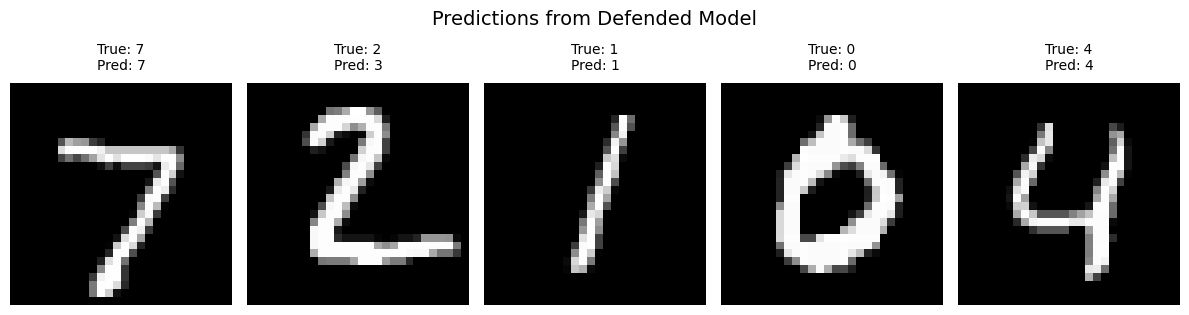

Final Accuracy (Defended Model): 92.63%
Final Precision (Defended Model): 0.93
Final F1-Score (Defended Model): 0.93


In [13]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import torch

# Apply Isolation Forest to Filter Poisoned Data
def apply_defense_with_isolation_forest(train_loader):
    features, labels = [], []
    for images, targets in train_loader:
        features.append(images.view(images.size(0), -1).numpy())  # Flatten images
        labels.extend(targets.numpy())
    features = np.vstack(features)
    labels = np.array(labels)

    # Train Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outlier_preds = iso_forest.fit_predict(features)  # Outlier detection (-1 for outliers)

    # Filter Outliers
    clean_indices = outlier_preds == 1
    clean_data = [(torch.tensor(features[i]).view(1, 28, 28), torch.tensor(labels[i]))
                  for i in range(len(labels)) if clean_indices[i]]

    defended_loader = torch.utils.data.DataLoader(clean_data, batch_size=64, shuffle=True)
    print(f"Defended dataset size: {len(clean_data)} samples remaining after filtering.")
    return defended_loader

# Visualize Predictions from Defended Model
def visualize_defended_predictions(model, test_loader, num_samples=5):
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(test_loader))  # Get a batch of test images
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get predicted labels

    # Plot the results
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
    for i in range(num_samples):
        axes[i].imshow(images[i].cpu().squeeze(), cmap="gray")
        axes[i].set_title(f"True: {labels[i].item()}\nPred: {preds[i].item()}", fontsize=10, pad=10)
        axes[i].axis("off")

    plt.suptitle("Predictions from Defended Model", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

# Defend the Poisoned Data
defended_train_loader = apply_defense_with_isolation_forest(poisoned_train_loader)

# Train the Defended Model
defended_model = SimpleCNN().to(device)
defended_losses, defended_accs, defended_precision, defended_f1 = train_model_with_metrics(
    defended_model, defended_train_loader, test_loader
)

# Visualize Predictions from Defended Model
visualize_defended_predictions(defended_model, test_loader)

# Print Final Metrics for the Defended Model
print(f"Final Accuracy (Defended Model): {defended_accs[-1]:.2f}%")
print(f"Final Precision (Defended Model): {defended_precision:.2f}")
print(f"Final F1-Score (Defended Model): {defended_f1:.2f}")


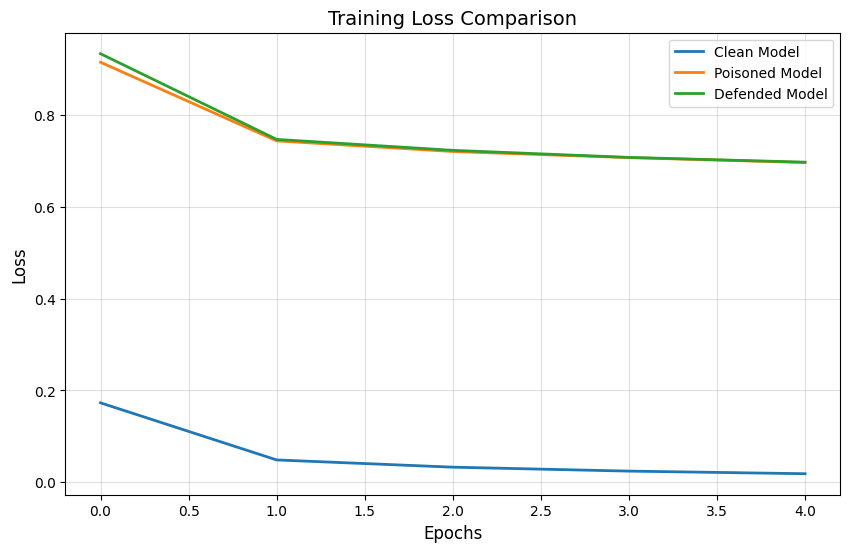

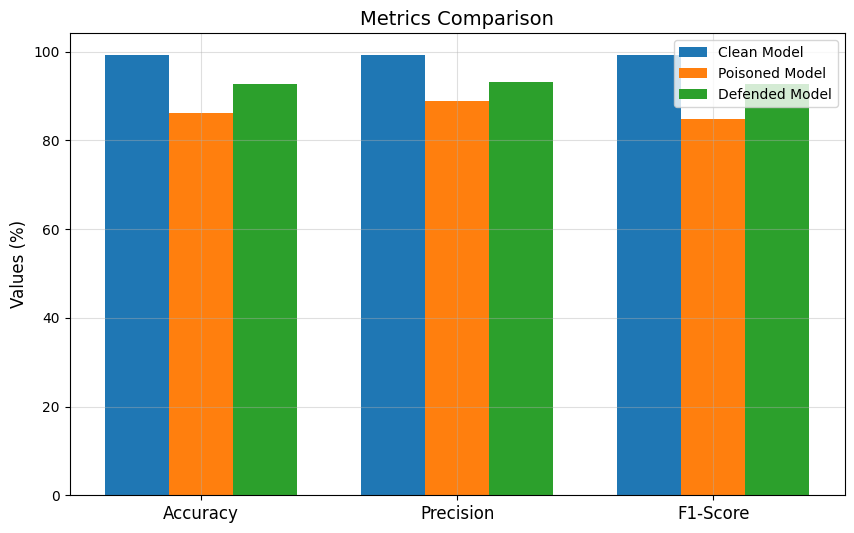

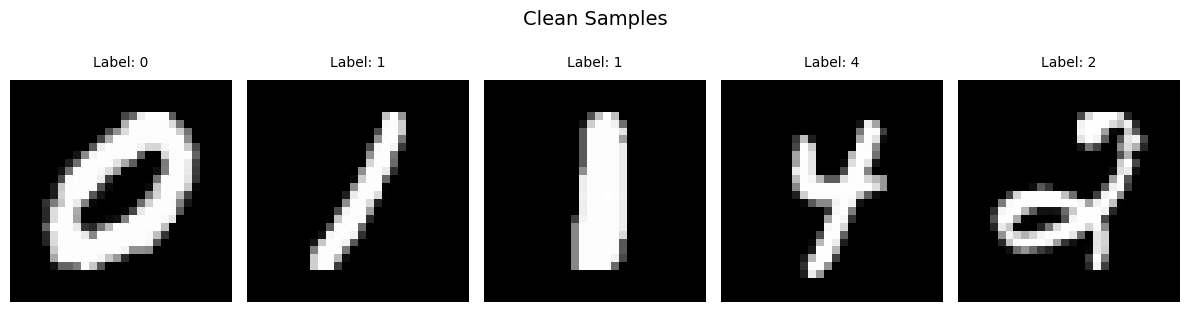

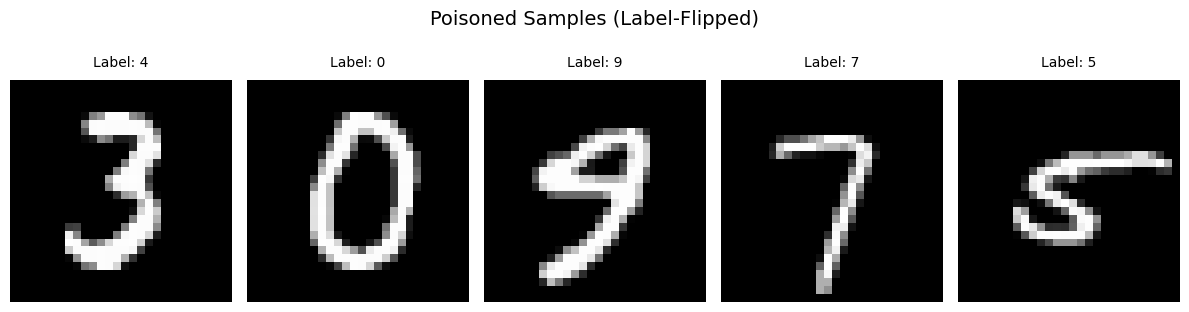

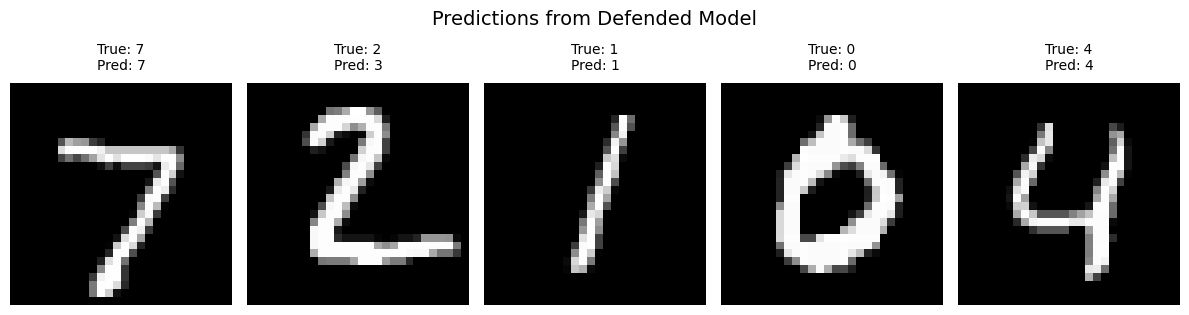

In [24]:
import matplotlib.pyplot as plt

# Training Loss Plot
def plot_training_losses(clean_losses, poisoned_losses, defended_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(clean_losses, label="Clean Model", linewidth=2)
    plt.plot(poisoned_losses, label="Poisoned Model", linewidth=2)
    plt.plot(defended_losses, label="Defended Model", linewidth=2)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training Loss Comparison", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.4)
    plt.show()

# Metrics Bar Plot
def plot_metrics(clean_acc, poisoned_acc, defended_acc,
                 clean_precision, poisoned_precision, defended_precision,
                 clean_f1, poisoned_f1, defended_f1):
    metrics = ["Accuracy", "Precision", "F1-Score"]
    clean_values = [clean_acc, clean_precision, clean_f1]
    poisoned_values = [poisoned_acc, poisoned_precision, poisoned_f1]
    defended_values = [defended_acc, defended_precision, defended_f1]

    x = range(len(metrics))
    width = 0.25

    plt.figure(figsize=(10, 6))
    plt.bar([p - width for p in x], clean_values, width, label="Clean Model")
    plt.bar(x, poisoned_values, width, label="Poisoned Model")
    plt.bar([p + width for p in x], defended_values, width, label="Defended Model")
    plt.xticks(x, metrics, fontsize=12)
    plt.ylabel("Values (%)", fontsize=12)
    plt.title("Metrics Comparison", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.4)
    plt.show()

# Example Predictions Subplot
def visualize_predictions(clean_model, poisoned_model, defended_model, test_loader, num_samples=5):
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        clean_preds = torch.argmax(clean_model(images), dim=1)
        poisoned_preds = torch.argmax(poisoned_model(images), dim=1)
        defended_preds = torch.argmax(defended_model(images), dim=1)

    fig, axes = plt.subplots(3, num_samples, figsize=(15, 6))
    models = ["Clean Model", "Poisoned Model", "Defended Model"]
    predictions = [clean_preds, poisoned_preds, defended_preds]

    for row in range(3):
        for col in range(num_samples):
            axes[row, col].imshow(images[col].cpu().squeeze(), cmap="gray")
            axes[row, col].set_title(f"True: {labels[col].item()}\nPred: {predictions[row][col].item()}", fontsize=8)
            axes[row, col].axis("off")
        axes[row, 0].set_ylabel(models[row], fontsize=10, labelpad=10)

    plt.suptitle("Example Predictions for Clean, Poisoned, and Defended Models", fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize Training Loss
plot_training_losses(clean_losses, poisoned_losses, defended_losses)

# Visualize Metrics
plot_metrics(clean_accuracies[-1], poisoned_accs[-1], defended_accs[-1],
             clean_precision*100, poisoned_precision*100, defended_precision*100,
             clean_f1*100, poisoned_f1*100, defended_f1*100)

# Visualize Predictions
visualize_samples(clean_train_loader, "Clean Samples")

# Visualize Poisoned Samples
visualize_samples(poisoned_train_loader, "Poisoned Samples (Label-Flipped)")

visualize_defended_predictions(defended_model, test_loader)
